In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import json
import numpy as np

stats = []
for i in open('../train_54/stat.json').readlines():
    stats.append(json.loads(i))
stats = np.array(stats[0])

In [5]:
import json
import numpy as np

stats_new = []
for i in open('./train_alexnet/stat.json').readlines():
    stats_new.append(json.loads(i))
stats_new = np.array(stats_new[0])

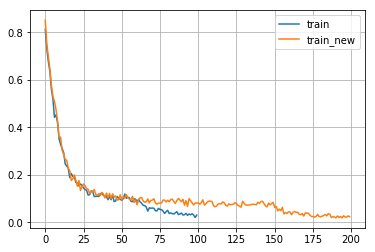

In [7]:
plt.plot([i['train-error-top1'] for i in stats], label='train')
plt.plot([i['train-error-top1'] for i in stats_new], label='train_new')
plt.grid()
plt.legend(loc='best')

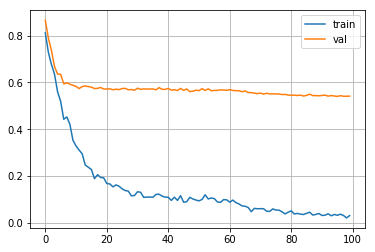

In [3]:
plt.plot([i['train-error-top1'] for i in stats], label='train')
plt.plot([i['val-error-top1'] for i in stats], label='val')
plt.grid()
plt.legend(loc='best')

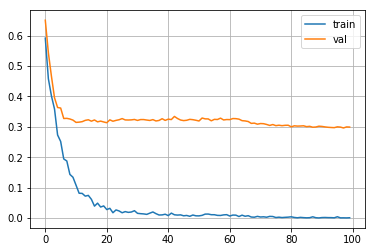

In [4]:
plt.plot([i['train-error-top5'] for i in stats], label='train')
plt.plot([i['val-error-top5'] for i in stats], label='val')
plt.grid()
plt.legend(loc='best')

In [8]:
d = load_chkpt_vars('./train2_bin8/model-365625')

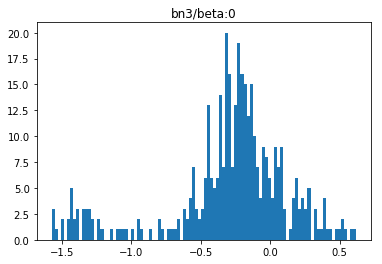

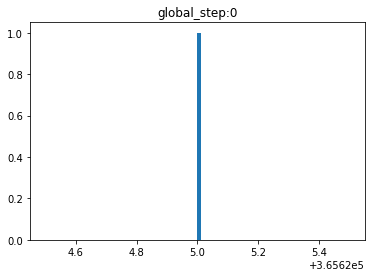

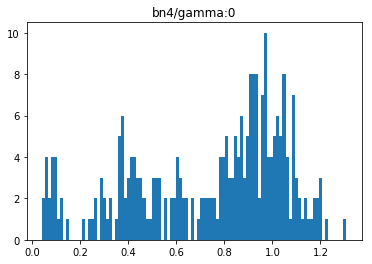

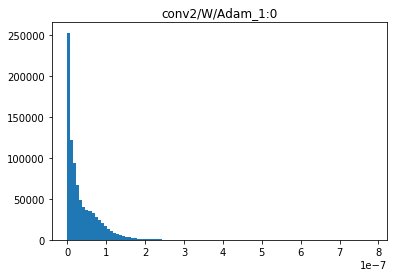

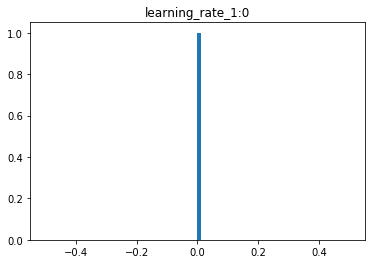

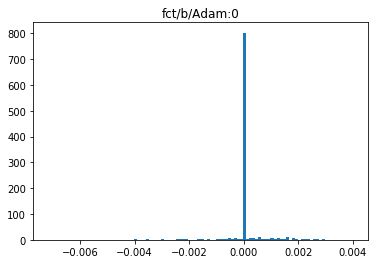

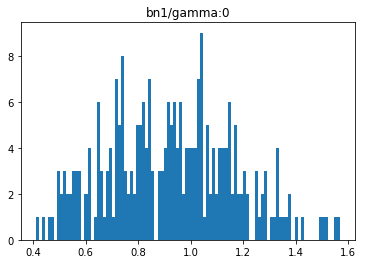

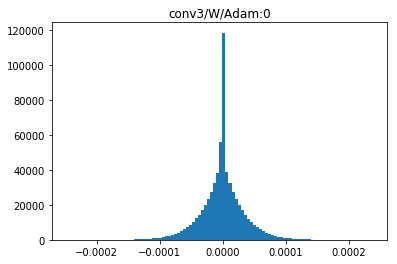

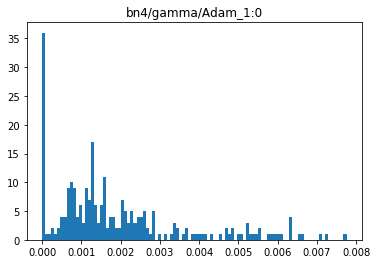

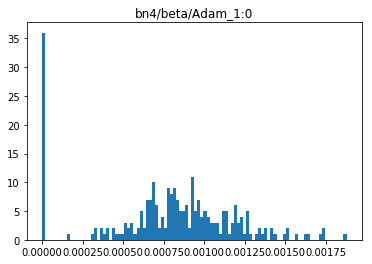

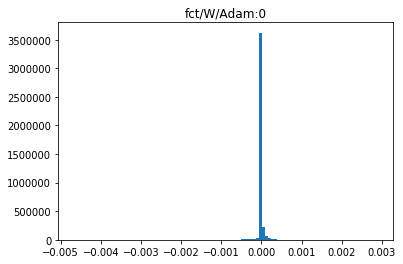

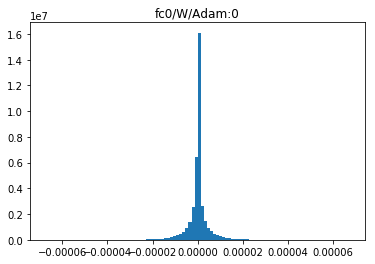

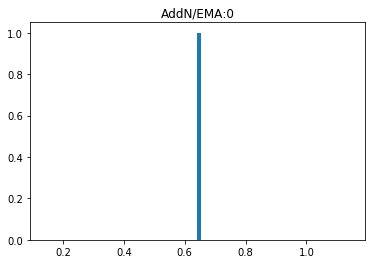

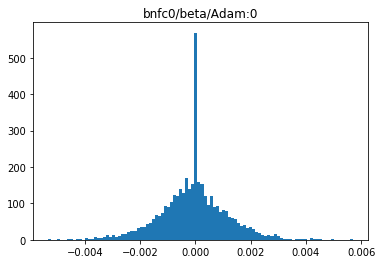

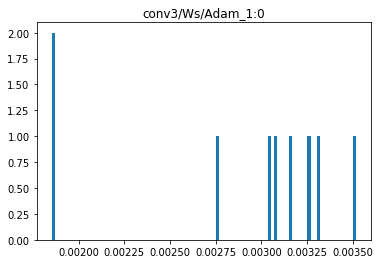

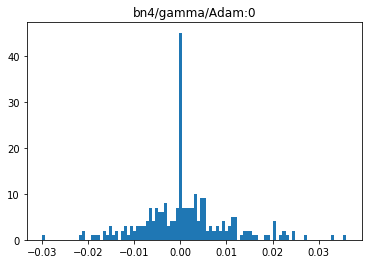

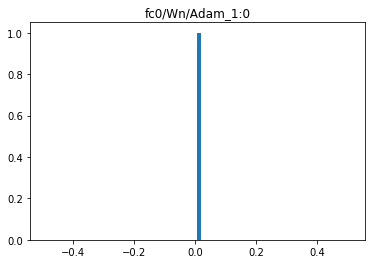

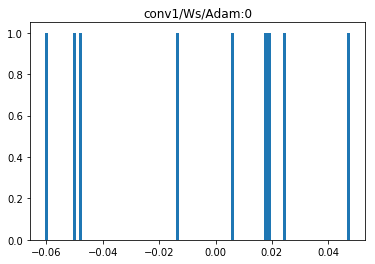

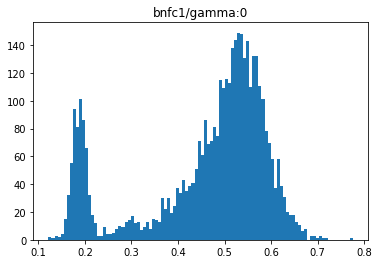

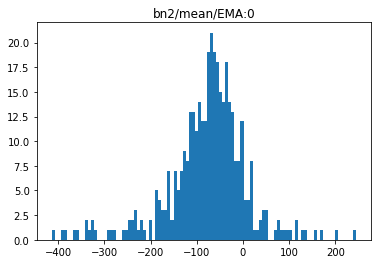

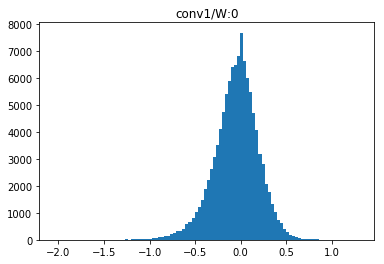

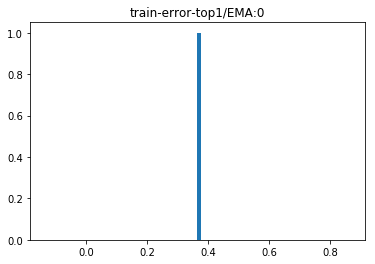

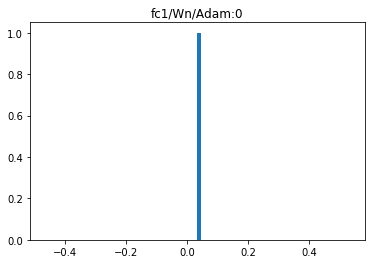

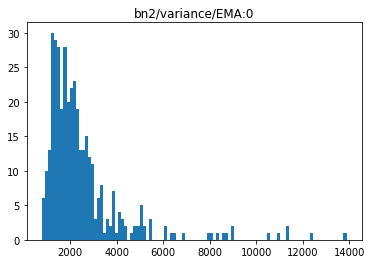

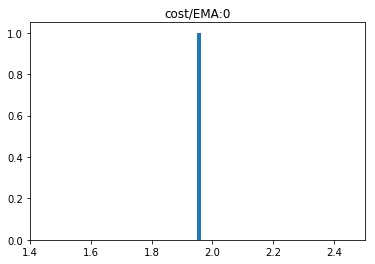

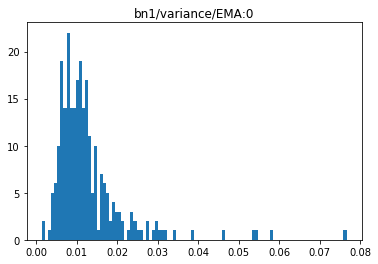

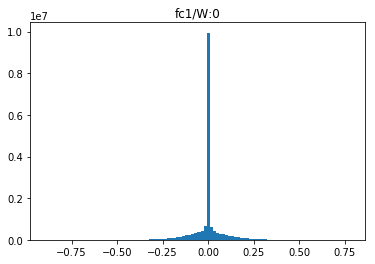

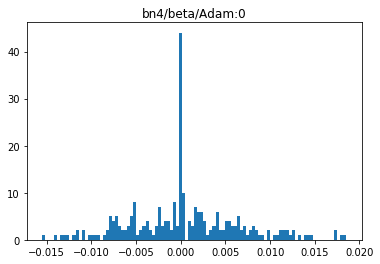

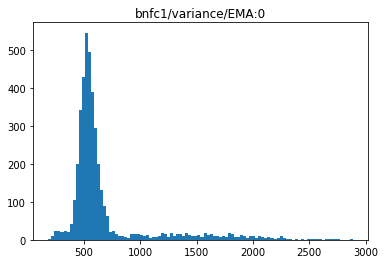

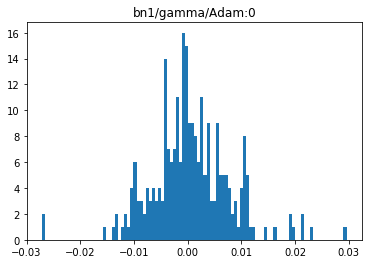

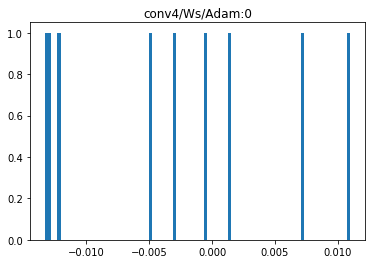

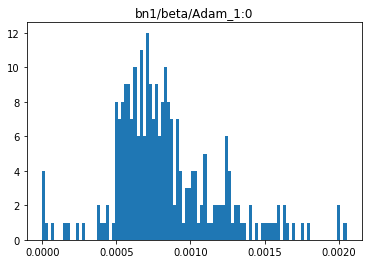

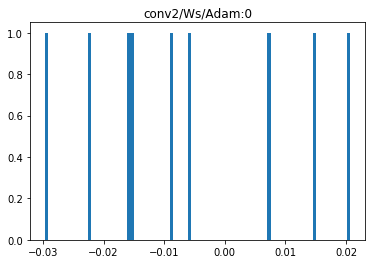

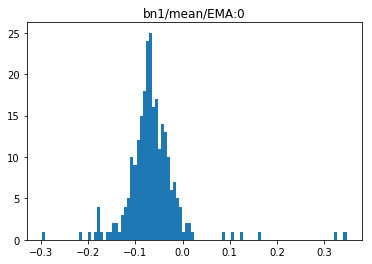

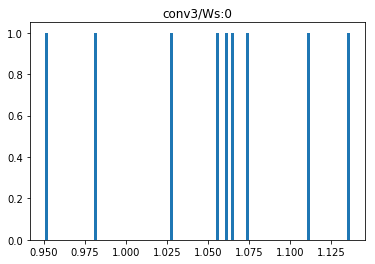

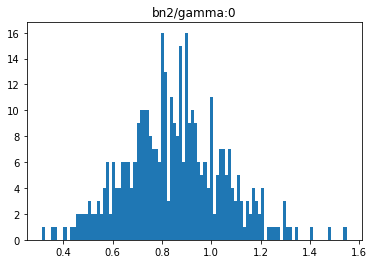

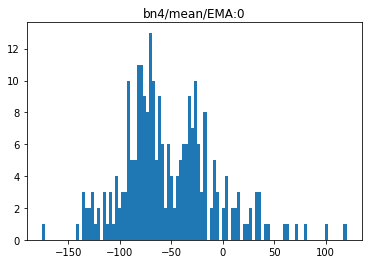

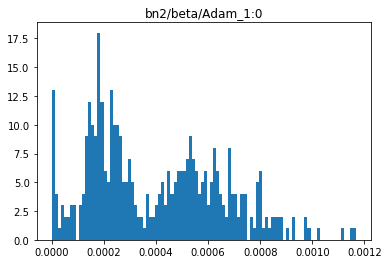

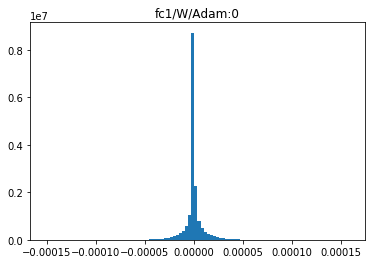

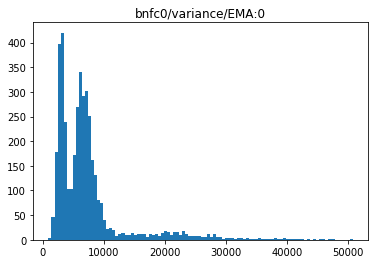

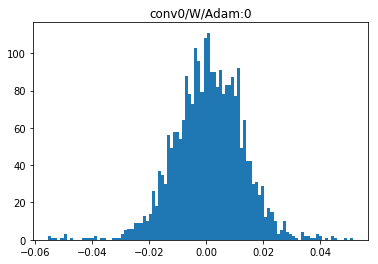

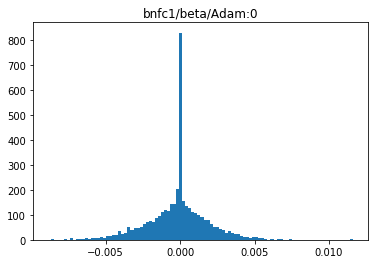

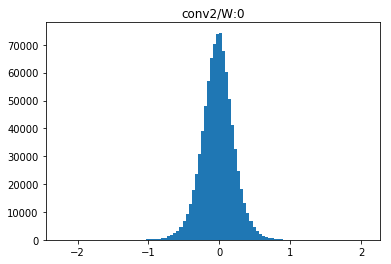

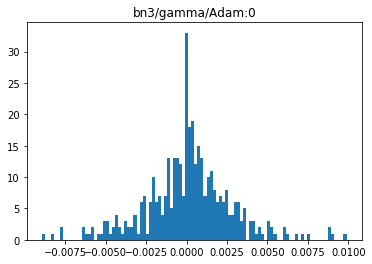

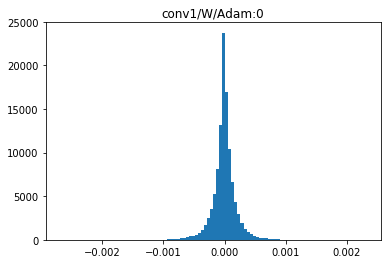

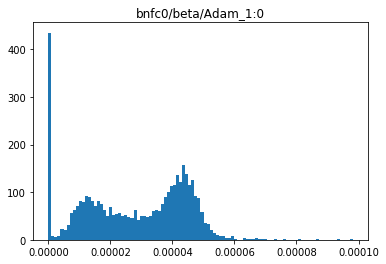

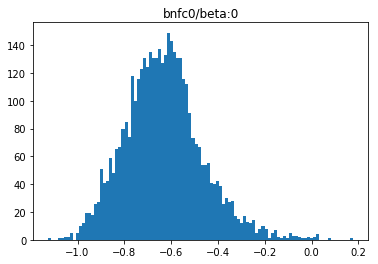

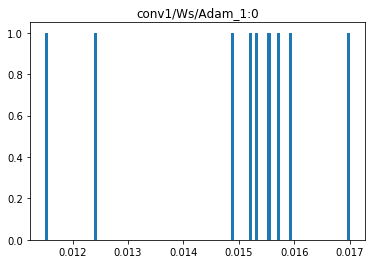

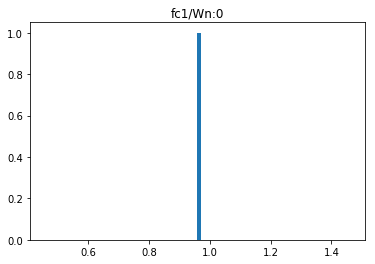

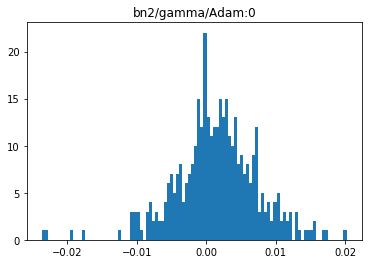

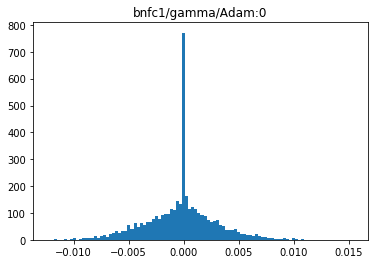

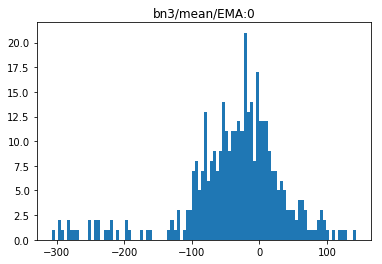

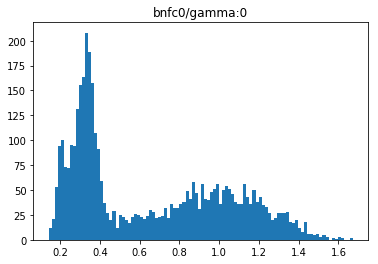

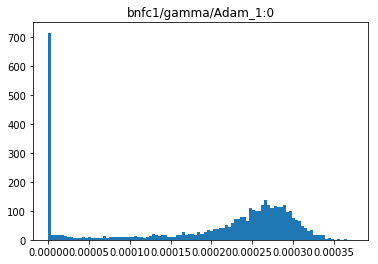

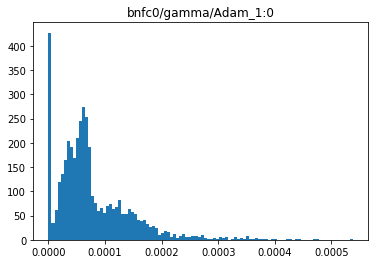

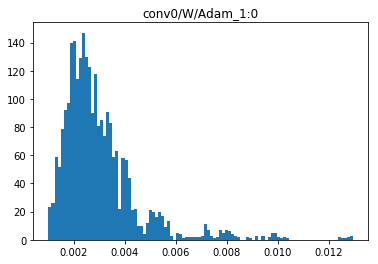

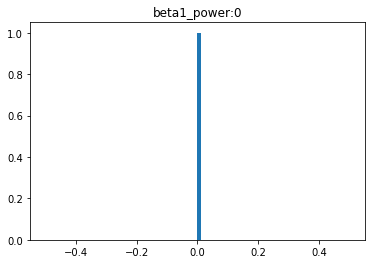

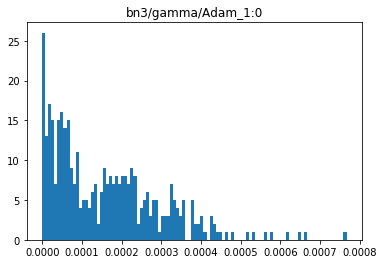

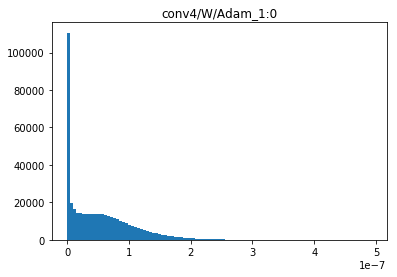

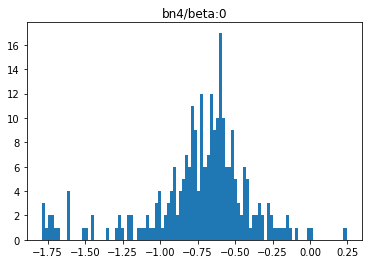

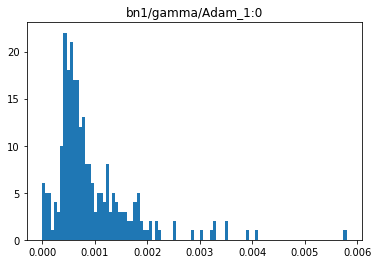

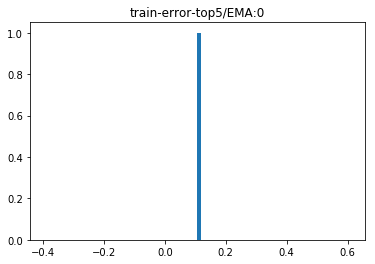

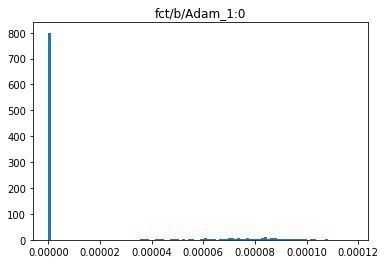

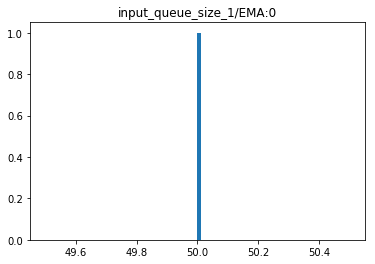

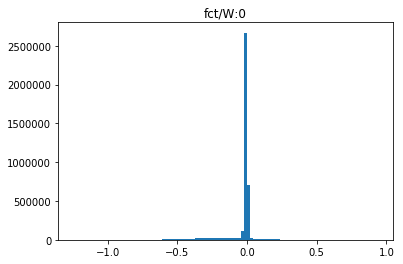

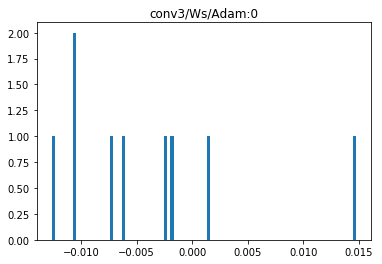

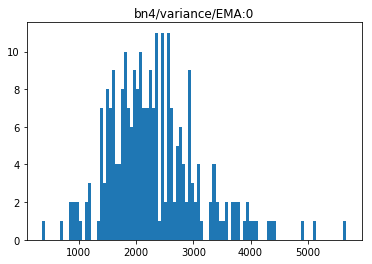

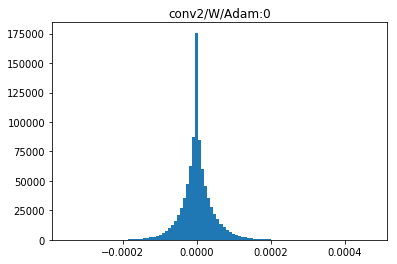

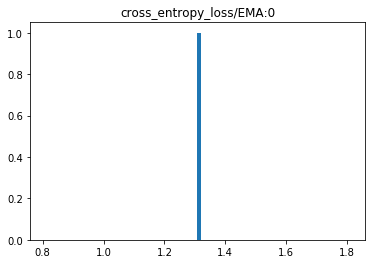

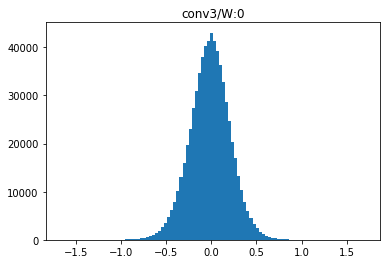

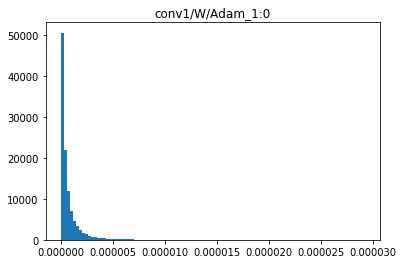

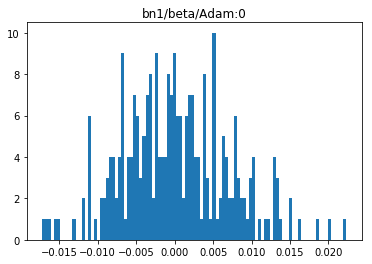

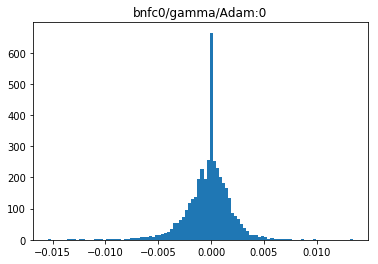

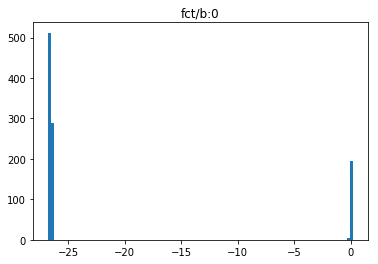

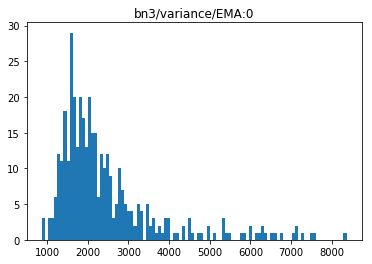

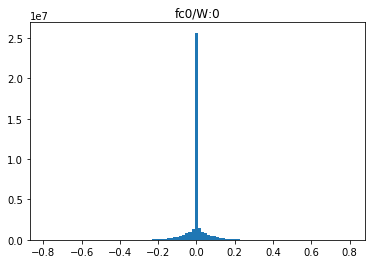

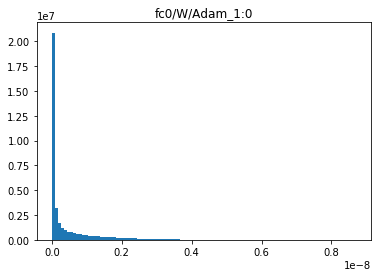

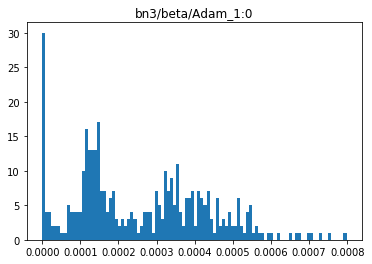

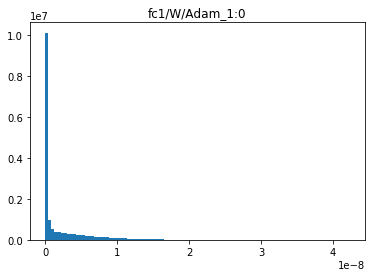

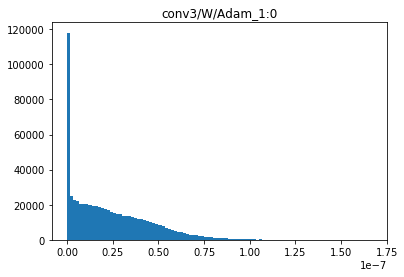

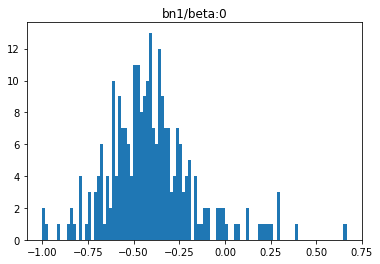

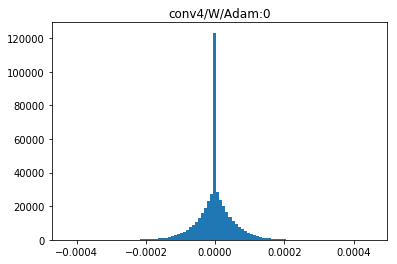

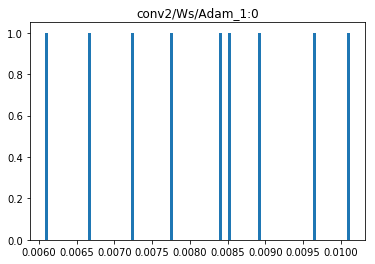

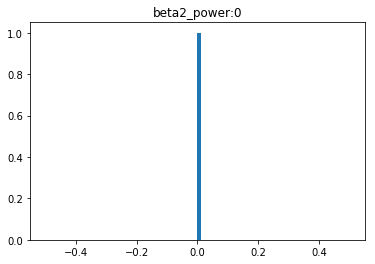

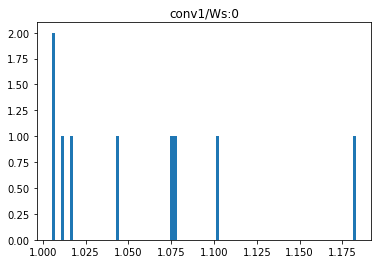

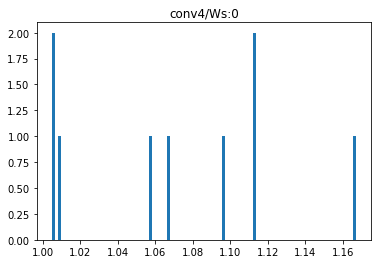

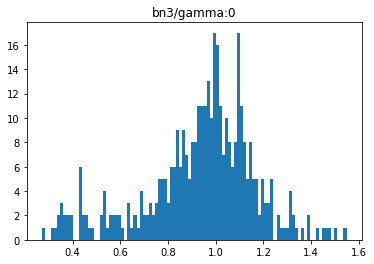

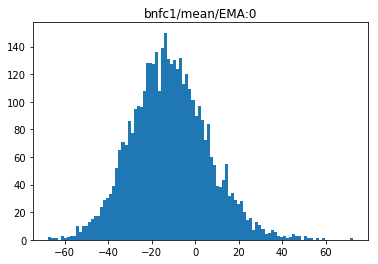

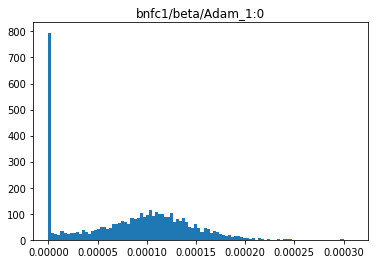

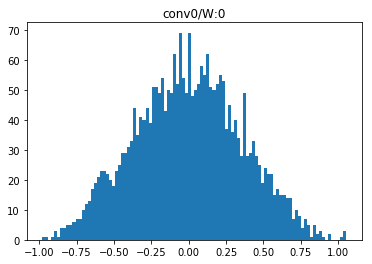

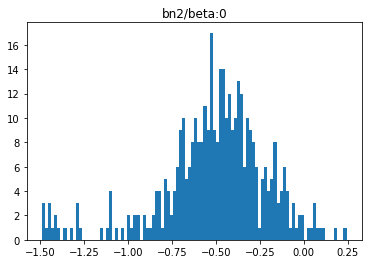

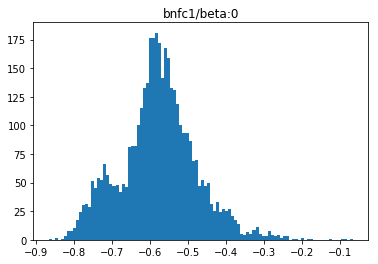

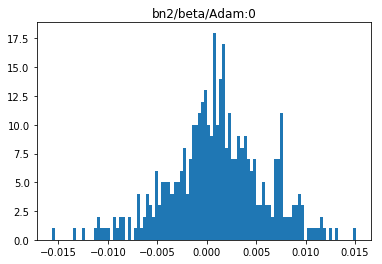

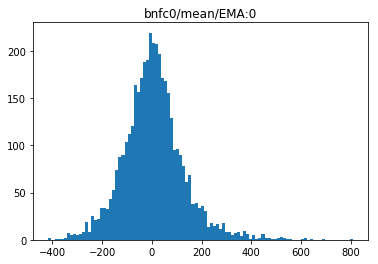

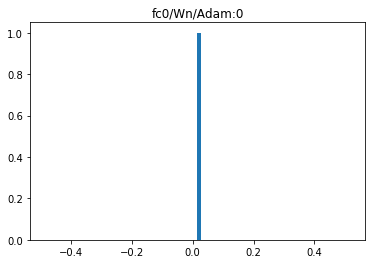

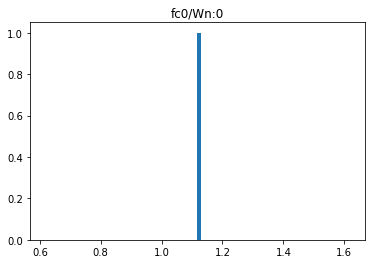

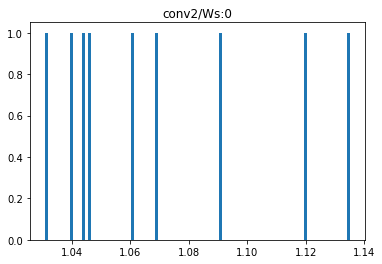

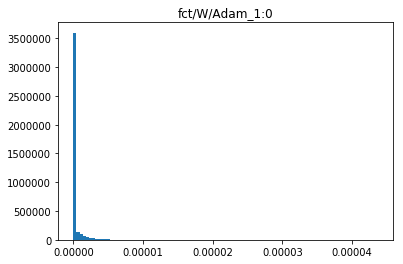

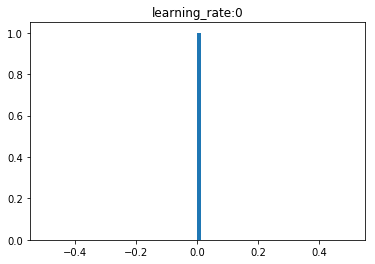

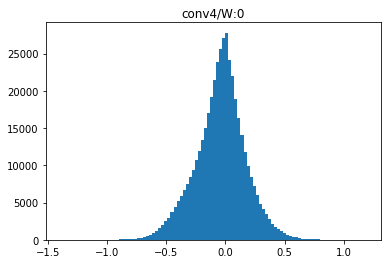

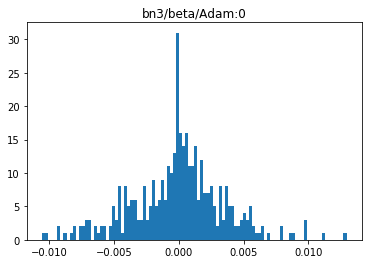

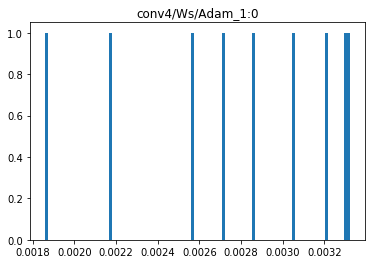

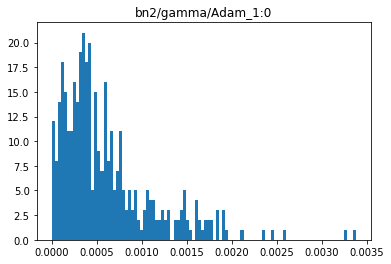

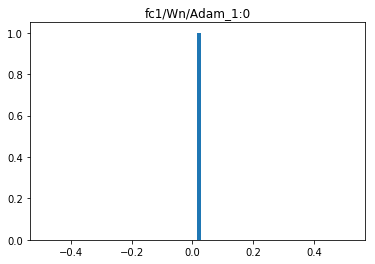

In [9]:
for key in d.keys():
    plt.title(key)
    plt.hist(d[key].flatten(), bins=100)[2]
    plt.show()

In [5]:
# -*- coding: utf-8 -*-
# File: varmanip.py

import numpy as np
import os
import pprint
import six
import tensorflow as tf

from tensorpack.utils import logger
#from ..utils import logger
#from .common import get_op_tensor_name

__all__ = ['SessionUpdate', 'dump_session_params',
           'load_chkpt_vars', 'save_chkpt_vars', 'get_checkpoint_path']


def get_savename_from_varname(
        varname, varname_prefix=None,
        savename_prefix=None):
    """
    Args:
        varname(str): a variable name in the graph
        varname_prefix(str): an optional prefix that may need to be removed in varname
        savename_prefix(str): an optional prefix to append to all savename
    Returns:
        str: the name used to save the variable
    """
    name = varname
    if varname_prefix is not None \
            and name.startswith(varname_prefix):
        name = name[len(varname_prefix) + 1:]
    if savename_prefix is not None:
        name = savename_prefix + '/' + name
    return name


class SessionUpdate(object):
    """ Update the variables in a session """

    def __init__(self, sess, vars_to_update):
        """
        Args:
            sess (tf.Session): a session object
            vars_to_update: a collection of variables to update
        """
        self.sess = sess
        self.name_map = {v.name: v for v in vars_to_update}

    @staticmethod
    def relaxed_value_for_var(value, var):
        """
        Returns a relaxed (possibly reshaped/upcast-ed) version of value,
        to be loaded to the given variable.
        Args:
            value (ndarray): an numpy array to be loaded to var
            var (tf.Variable):
        Returns:
            ndarray: a possibly reshaped or casted version of value
        """
        assert isinstance(var, tf.Variable)
        name = var.op.name

        # check incompatible shape
        varshape = tuple(var.get_shape().as_list())
        if varshape != value.shape:
            # TODO only allow reshape when shape different by empty axis
            if np.prod(varshape) != np.prod(value.shape):
                raise ValueError(
                    "Trying to load a tensor of shape {} into the variable '{}' whose shape is {}.".format(
                        value.shape, name, varshape))
            logger.warn("The tensor is reshaped from {} to {} when assigned to '{}'".format(
                value.shape, varshape, name))
            value = value.reshape(varshape)

        # fix some common type incompatibility problems, but not all
        def upcast(vartype, valtype):
            # allow up-casting
            if vartype == tf.float64 and valtype == np.float32:
                return np.float64
            if vartype in [tf.int64, tf.int32] and valtype in [np.int32, np.int16, np.int8]:
                return np.int64 if vartype == tf.int64 else np.int32
            return None

        if hasattr(value, 'dtype'):
            vartype = var.value().dtype
            if vartype != value.dtype:
                msg = "Variable {} has dtype {} but was given a value of dtype {}.".format(name, vartype, value.dtype)
                newtype = upcast(var.dtype.base_dtype, value.dtype)
                if newtype is not None:
                    value = newtype(value)
                    logger.warn(msg + " Load it after casting!")
                else:
                    assert vartype == value.dtype, msg
        return value

    def update(self, prms):
        """
        Args:
            prms(dict): dict of {variable name: value}
                Any name in prms must be in the graph and in vars_to_update.
        """
        with self.sess.as_default():
            fetches = []
            feeds = {}
            for name, value in six.iteritems(prms):
                assert name in self.name_map
                var = self.name_map[name]
                fetches.append(var.initializer)
                # This is the implementation of `var.load`
                feeds[var.initializer.inputs[1]] = SessionUpdate.relaxed_value_for_var(value, var)
            self.sess.run(fetches, feed_dict=feeds)


def dump_session_params(path):
    """
    Dump value of all TRAINABLE + MODEL variables to a dict, and save as
    npz format (loadable by :func:`sessinit.get_model_loader`).
    Args:
        path(str): the file name to save the parameters. Must ends with npz.
    """
    # save variables that are GLOBAL, and either TRAINABLE or MODEL
    var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    var.extend(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES))
    # TODO dedup
    assert len(set(var)) == len(var), "TRAINABLE and MODEL variables have duplication!"
    gvars = set([k.name for k in tf.global_variables()])
    var = [v for v in var if v.name in gvars]
    result = {}
    for v in var:
        result[v.name] = v.eval()
    save_chkpt_vars(result, path)


def save_chkpt_vars(dic, path):
    """
    Save variables in dic to path.
    Args:
        dic: {name: value}
        path: save as npz if the name ends with '.npz', otherwise save as a checkpoint.
    """
    logger.info("Variables to save to {}:".format(path))
    keys = sorted(list(dic.keys()))
    logger.info(pprint.pformat(keys))

    assert not path.endswith('.npy')
    if path.endswith('.npz'):
        np.savez_compressed(path, **dic)
    else:
        with tf.Graph().as_default(), \
                tf.Session() as sess:
            for k, v in six.iteritems(dic):
                k = get_op_tensor_name(k)[0]
                _ = tf.Variable(name=k, initial_value=v)    # noqa
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            saver.save(sess, path, write_meta_graph=False)


def get_checkpoint_path(model_path):
    """
    Work around TF problems in checkpoint path handling.
    Args:
        model_path: a user-input path
    Returns:
        str: the argument that can be passed to NewCheckpointReader
    """
    if os.path.basename(model_path) == model_path:
        model_path = os.path.join('.', model_path)  # avoid #4921 and #6142
    if os.path.basename(model_path) == 'checkpoint':
        assert tf.gfile.Exists(model_path), model_path
        model_path = tf.train.latest_checkpoint(os.path.dirname(model_path))
        # to be consistent with either v1 or v2

    # fix paths if provided a wrong one
    new_path = model_path
    if '00000-of-00001' in model_path:
        new_path = model_path.split('.data')[0]
    elif model_path.endswith('.index'):
        new_path = model_path.split('.index')[0]
    if new_path != model_path:
        logger.info(
            "Checkpoint path {} is auto-corrected to {}.".format(model_path, new_path))
        model_path = new_path
    assert tf.gfile.Exists(model_path) or tf.gfile.Exists(model_path + '.index'), model_path
    return model_path


def load_chkpt_vars(model_path):
    """ Load all variables from a checkpoint to a dict.
    Args:
        model_path(str): path to a checkpoint.
    Returns:
        dict: a name:value dict
    """
    model_path = get_checkpoint_path(model_path)
    reader = tf.train.NewCheckpointReader(model_path)
    var_names = reader.get_variable_to_shape_map().keys()
    result = {}
    for n in var_names:
        result[n] = reader.get_tensor(n)
    return result


def is_training_name(name):
    """
    **Guess** if this variable is only used in training.
    Only used internally to avoid too many logging. Do not use it.
    """
    # TODO: maybe simply check against TRAINABLE_VARIABLES and MODEL_VARIABLES?
    # TODO or use get_slot_names()
    name = get_op_tensor_name(name)[0]
    if name.endswith('/Adam') or name.endswith('/Adam_1'):
        return True
    if name.endswith('/Momentum'):
        return True
    if name.endswith('/Adadelta') or name.endswith('/Adadelta_1'):
        return True
    if name.endswith('/RMSProp') or name.endswith('/RMSProp_1'):
        return True
    if name.endswith('/Adagrad'):
        return True
    if name.startswith('EMA/') or '/EMA/' in name:  # all the moving average summaries
        return True
    if name.startswith('AccumGrad') or name.endswith('/AccumGrad'):
        return True
    if name.startswith('apply_gradients'):
        return True
    return False

[0310 22:02:12 @logger.py:120] WRN Failed to import 'tensorflow', PennTreeBank won't be available'
[0310 22:02:12 @logger.py:120] WRN Failed to import 'lmdb', LMDBData won't be available'

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[0310 22:02:16 @logger.py:120] WRN Failed to import 'lmdb', dump_dataflow_to_lmdb won't be available'
